# Criteria Development Interactive Notebook

# Set Up

## Installation and Dependencies

In [47]:
%load_ext autoreload
%autoreload 2

# Standard imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from pathlib import Path
import json
from uuid import uuid4

# Geospatial processing packages
from matplotlib import pyplot as plt
from shapely import wkt
import geopandas as gpd
import folium



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# Util imports
sys.path.append("../../")  # include parent directory
from src.criteria_scoring import CriteriaScoring
from src.settings import DATA_DIR, CONFIG_DIR, PROJ_CRS

## Set up parameters

## Load Data

In [49]:
filepath = DATA_DIR / "csv/features.csv"
tile_features = pd.read_csv(filepath)

In [50]:
tile_features.shape

(72321, 34)

In [51]:
tile_features.columns

Index(['Unnamed: 0', 'fid', 'name', 'category', 'class', 'ADM1_PCODE',
       'ADM1_EN', 'ADM1_EN_Export', 'ADM2_PCODE', 'ADM2_EN', 'ADM3_PCODE',
       'ADM3_EN', 'ADM4_PCODE', 'ADM4_EN', 'fw4a_status', 'fw4a_site',
       'geometry', 'dist_nearest_road', 'road_type', 'pop_men_1km',
       'pop_women_1km', 'pop_total_1km', 'otherpois_1km', 'fw4a_1km',
       'broadband_downspeed', 'broadband_upspeed', 'mobile_downspeed',
       'mobile_upspeed', 'poverty_incidence', 'ntl_mean_rad', 'hazard_mean',
       'insurgency_count', 'urban_rural', 'coords'],
      dtype='object')

In [52]:
tile_features.drop(["Unnamed: 0"], axis=1, inplace=True)

In [53]:
# Check for duplicates
tile_features.drop_duplicates(subset=["geometry"], inplace=True)

In [54]:
tile_features.shape

(72321, 33)

In [55]:
tile_features.describe()

,fid,dist_nearest_road,pop_men_1km,pop_women_1km,pop_total_1km,otherpois_1km,fw4a_1km,broadband_downspeed,broadband_upspeed,mobile_downspeed,mobile_upspeed,poverty_incidence,ntl_mean_rad,hazard_mean,insurgency_count
count,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000,72321.000000
mean,36161.000000,199.534451,514.616571,510.549771,1025.166342,8.200937,1.103386,49.994911,49.129561,26.283919,6.069465,18.141557,4.249447,0.129666,3.516613
std,20877.418746,880.648014,941.223351,959.853752,1898.934757,15.601913,3.363488,39.646088,39.903664,26.891162,5.356276,14.543848,9.008314,0.118217,10.598286
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,18081.000000,11.830748,117.000000,112.000000,229.000000,1.000000,0.000000,8.399833,6.054750,0.000000,0.000000,6.200000,0.000000,0.027340,1.000000
50%,36161.000000,32.159696,250.000000,241.000000,491.000000,2.000000,0.000000,55.478625,55.175533,21.014500,6.165125,14.900000,0.672998,0.098708,1.000000
75%,54241.000000,97.835371,540.000000,531.000000,1071.000000,8.000000,0.000000,83.905667,83.007833,40.784250,9.939400,26.700000,3.115638,0.202793,1.000000
max,72321.000000,35248.828142,19099.000000,19244.000000,38343.000000,152.000000,48.000000,352.483000,419.239000,443.858000,51.250000,88.900000,100.948295,0.841065,74.000000


In [56]:
tile_features = gpd.GeoDataFrame(
    tile_features, geometry=tile_features.geometry.apply(wkt.loads)
)

# Criteria Testing

## Define Criteria

In [57]:
# Adjust scoring implementation here. Update criteria date and version to track changes, do not overwrite config files
criteria_ver = "20230412_v1"
criteria_config = {
    "criteria_name": criteria_ver,
    "date": "2023-02-21",
    "is_weighted": True,
    "scoring_thresholds": {
        # column_name:(low_threshold, high_threshold, direction)
        "dist_nearest_road": (0, 1_000, "low_val_high_score", 10),
        "ntl_mean_rad": (5, 50, "low_val_high_score", 10),
        "otherpois_1km": (0, 20, "low_val_high_score", 10),
        "fw4a_1km": (0, 5, "low_val_high_score", 10),
        "broadband_downspeed": (0, 150_000, "low_val_high_score", 10),
        "mobile_downspeed": (0, 150_000, "low_val_high_score", 10),
        "hazard_mean": (0, 0.12, "high_val_high_score", 10),
        "poverty_incidence": (0, 78.5, "high_val_high_score", 10),
        "pop_total_1km": (1_000, 5_000, "high_val_high_score", 10),
        "insurgency_count": (0, 3, "low_val_high_score", 10),
    },
    "binary_filter": {},
    "direct_score_mapping": {},
    "threshold_filter": {
        # column_name:(threshold, filter direction)
    },
    "tile_score_threshold": 0.5,
    "land_area_ha_threshold": 30,
    "group_by_tile_class": True,
    "threshold_m_coast_tile_counting": 500,
    "min_tiles_near_coast": 10,
    "crs_proj": PROJ_CRS,
}

In [58]:
# export parameters as config files; this does not allow overwritting existing files
export_config_json = CONFIG_DIR / (criteria_config["criteria_name"] + ".json")
if export_config_json.is_file():
    print(f"{export_config_json} already exists! Please do not rewrite criteria.")
else:
    with open(export_config_json, "w") as write_file:
        json.dump(criteria_config, write_file, indent=4)

/home/avell/site-scoring-template/notebooks/03_analytics/01_criteria_development/../../../src/config/20230412_v1.json already exists! Please do not rewrite criteria.


In [59]:
# load and check criteria config
CONFIG_JSON = CONFIG_DIR / f"{criteria_ver}.json"
with open(CONFIG_JSON, "r") as read_file:
    criteria_config = json.load(read_file)
criteria_config

{'criteria_name': '20230412_v1',
 'date': '2023-02-21',
 'is_weighted': True,
 'scoring_thresholds': {'dist_nearest_road': [0,
   1000,
   'low_val_high_score',
   10],
  'ntl_mean_rad': [5, 50, 'low_val_high_score', 10],
  'otherpois_1km': [0, 20, 'low_val_high_score', 10],
  'fw4a_1km': [0, 5, 'low_val_high_score', 10],
  'broadband_downspeed': [0, 150000, 'low_val_high_score', 10],
  'mobile_downspeed': [0, 150000, 'low_val_high_score', 10],
  'hazard_mean': [0, 0.12, 'high_val_high_score', 10],
  'poverty_incidence': [0, 78.5, 'high_val_high_score', 10],
  'pop_total_1km': [1000, 5000, 'high_val_high_score', 10],
  'insurgency_count': [0, 3, 'low_val_high_score', 10]},
 'binary_filter': {},
 'direct_score_mapping': {},
 'threshold_filter': {},
 'tile_score_threshold': 0.5,
 'land_area_ha_threshold': 30,
 'group_by_tile_class': True,
 'threshold_m_coast_tile_counting': 500,
 'min_tiles_near_coast': 10,
 'crs_proj': 'EPSG:3123'}

## Run Criteria on Data

In [60]:
%%time
criteria_scoring = CriteriaScoring(criteria_config)
tile_scores = criteria_scoring.apply_tile_criteria(tile_features)
tile_scores.head(2)

CPU times: user 297 ms, sys: 0 ns, total: 297 ms
Wall time: 294 ms


,fid,name,category,class,ADM1_PCODE,ADM1_EN,ADM1_EN_Export,ADM2_PCODE,ADM2_EN,ADM3_PCODE,...,otherpois_1km_score,fw4a_1km_score,broadband_downspeed_score,mobile_downspeed_score,hazard_mean_score,poverty_incidence_score,pop_total_1km_score,insurgency_count_score,tile_score,tile_class
0,1,MALITA AIRPORT,Airport,Transport,PH110000000,Region ⅩⅠ,Region XI,PH118600000,Davao Occidental,PH118603000,...,8.0,10.0,9.997643,9.996253,10.0,4.56051,0.0,6.666667,68.274662,1
1,2,CULAMAN BARANGAY HEALTH STATION,Barangay Health Station,Health,PH110000000,Region ⅩⅠ,Region XI,PH118600000,Davao Occidental,PH118603000,...,10.0,10.0,9.999342,9.999370,10.0,4.56051,0.0,6.666667,78.454375,1


In [70]:
perc_pass = (
    tile_scores[tile_scores.tile_score > 70].shape[0] / tile_scores.shape[0]
) * 100
print(f"{round(perc_pass, 2)}% scored above 70%.")

6.25% scored above 70%.


In [71]:
tile_scores["tile_score"].describe()

count    72321.000000
mean        61.017618
std          6.622837
min         36.621982
25%         57.324077
50%         61.255133
75%         65.763512
max         86.637639
Name: tile_score, dtype: float64

<Axes: >

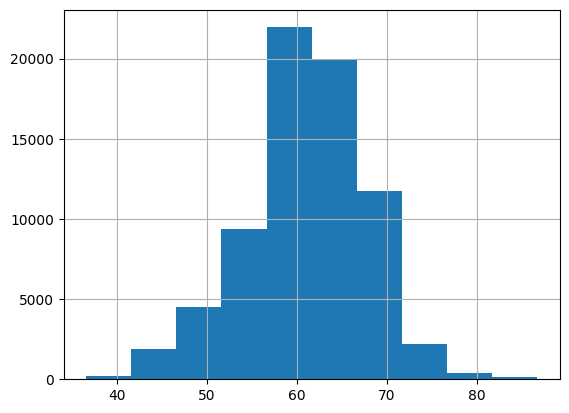

In [72]:
tile_scores["tile_score"].hist()

# Visualization by Province

## Map set-up

In [73]:
tile_scores_subset = tile_scores[tile_scores.ADM2_EN == "Aurora"]

In [75]:
tile_scores_subset = tile_scores_subset[
    [
        "name",
        "category",
        "class",
        "ADM1_EN",
        "ADM2_EN",
        "ADM3_EN",
        "ADM4_EN",
        "dist_nearest_road",
        "road_type",
        "pop_total_1km",
        "otherpois_1km",
        "fw4a_1km",
        "broadband_downspeed",
        "mobile_downspeed",
        "ntl_mean_rad",
        "insurgency_count",
        "hazard_mean",
        "poverty_incidence",
        "tile_score",
        "geometry",
    ]
]

In [76]:
tile_scores_subset["geometry"] = gpd.GeoSeries.from_wkt(tile_scores_subset["geometry"])

TypeError: Expected bytes or string, got Point

In [77]:
tile_scores_subset = gpd.GeoDataFrame(tile_scores_subset, geometry="geometry")

In [78]:
gdf_centroid_lat, gdf_centroid_lon = (
    tile_scores_subset.geometry.y.mean(),
    tile_scores_subset.geometry.x.mean(),
)

In [79]:
# replace the basemap on the display
map = folium.Map(
    location=[gdf_centroid_lat, gdf_centroid_lon],
    zoom_start=10,
    control_scale=True,
    tiles="cartodb positron",
)  # this let's us choose a basemap

## Choropleth Map based on Score

In [80]:
%%time
tile_scores_subset.explore(m=map, column="tile_score", cmap="RdYlGn", popup=True)

CPU times: user 619 ms, sys: 996 ms, total: 1.61 s
Wall time: 1.05 s


In [ ]:
# Please use uuid4 for naming the html to gurantee you are not overwriting anything
# id = uuid4()
# map.save(f"{id}.html")

In [98]:
map.save(f"{DATA_DIR}/html/{criteria_ver}.html")

In [100]:
!~/google-cloud-sdk/bin/gsutil -m cp $DATA_DIR'/html/'$criteria_ver'.html' gs://public-tm8-map-dev

Copying file:///home/avell/site-scoring-template/notebooks/03_analytics/01_criteria_development/../../../data/html/20230412_v1.html [Content-Type=text/html]...
- [1/1 files][272.0 KiB/272.0 KiB] 100% Done                                    
Operation completed over 1 objects/272.0 KiB.                                    


In [90]:
url = f"https://storage.googleapis.com/public-tm8-map-dev/{criteria_ver}.html"
print(f"URL: {url}")

URL: https://storage.googleapis.com/public-tm8-map-dev/20230412_v1.html
